# Chaos Scheduler

The purpose of this notebook is to document the decision of how to implement the following.

**Definition:** <u>link loss chaos</u> is the random loss of availability of links between edge servers in time, together with random restoration. 

Ingredients:
1. a mechanism for link loss
    - I chose to use the scheduler in the file chaos_scheduler.py. This can be generalized later to chos on other network components like nodes. 
2. rerouting upon link loss
    - I updated the code to run the method `set_communication _path` on each timestep. This is a specious modeling feature; it may be considered bad practice to be willing to change routing path on each timestep in real life. 
3. penalty definiteion and measurement. 
    - as presented below I have broken the penalty I wish for RL agents to consider into the following components
        - energy use
        - average delay 
        - SLA delay violations
        - SLA no path violations


Link 32 removed at t=1.
Link 22 removed at t=5.
Link 32 replaced  at t=5
Link 4 removed at t=10.
Link 32 removed at t=10.
Link 32 replaced  at t=11
Link 31 removed at t=12.
Link 22 replaced  at t=13
Link 27 removed at t=13.
Link 12 removed at t=15.
Link 23 removed at t=15.
Link 25 removed at t=18.
Link 28 removed at t=18.
Link 26 removed at t=21.
Link 31 replaced  at t=22
Link 8 removed at t=23.
Link 27 replaced  at t=23
Link 26 replaced  at t=24
Link 12 replaced  at t=26
Link 21 removed at t=28.


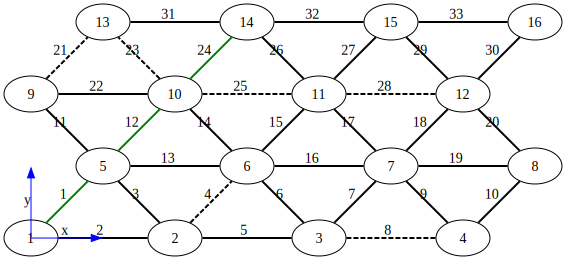

In [1]:
import edge_sim_py as esp
        
def place_and_migrate_to_least_utilized(parameters):
    for service in esp.Service.all():
        if not service.being_provisioned:
            edge_servers = sorted(
                esp.EdgeServer.all(), key=lambda s: (
                    (s.cpu - s.cpu_demand) 
                   * (s.memory - s.memory_demand) 
                   * (s.disk - s.disk_demand)
                  ) ** (1/3),
                reverse=True,
            )
            for edge_server in edge_servers: # use ordered list
                if edge_server.has_capacity_to_host(service=service):
                    if service.server != edge_server:
                        # print(f"[STEP {parameters['current_step']}] Migrating {service} From {service.server} to {edge_server}")
                        service.provision(target_server=edge_server)
                        break

def stop_on_n_steps(model: object):    
    return model.schedule.steps == 30

simulator = esp.Simulator(tick_duration=1,tick_unit="seconds",
    stopping_criterion=stop_on_n_steps,
    resource_management_algorithm=place_and_migrate_to_least_utilized,
    scheduler=esp.activation_schedulers.ChaosScheduler,
)
simulator.initialize(input_file="../edgesimpy-tutorials/datasets/sample_dataset2.json")
simulator.run_model()

user = esp.User.all()[5]
path = user.communication_paths[str(user.applications[0].id)][0]

def path_to_edge_filter(path):
    path_edges_by_id = [{str(path[i]),str(path[i+1])} for i in range(len(path) -1 )]
    edge_filter = [ {str(node.id) for node in edge.nodes} in path_edges_by_id 
              for edge in esp.NetworkLink.all()]
    return edge_filter

simulator.visualize(path_to_edge_filter(path))

## Check: repaired links have delay=original_delay

Find a network like that fails and is repaired. 

In [2]:
import pandas as pd

df = pd.DataFrame(data = simulator.agent_metrics["NetworkLink"])
repaired_filter = (df["Repaired"]==True)

repaired_link = df[repaired_filter]["Object"].unique()[0]

link_n_filter = (df["Object"] == repaired_link)
df[link_n_filter]

,Object,Time Step,Link ID,Original Delay,Delay,Active,Failed,Repaired
31,NetworkLink_32,0,32,0,5.0,True,False,False
64,NetworkLink_32,1,32,5,5.0,True,False,False
97,NetworkLink_32,2,32,5,inf,False,True,False
130,NetworkLink_32,3,32,5,inf,False,True,False
163,NetworkLink_32,4,32,5,inf,False,True,False
196,NetworkLink_32,5,32,5,inf,False,True,False
229,NetworkLink_32,6,32,5,5.0,True,True,True
262,NetworkLink_32,7,32,5,5.0,True,True,True
295,NetworkLink_32,8,32,5,5.0,True,True,True
328,NetworkLink_32,9,32,5,5.0,True,True,True


# Penalty each timestep


For RL I will want a reward function that is a weighted sum of values of instantaneous values. 

Let
- $R$ be the reward
- $E$ be energy consumption
- $D$ be the mean of delays
- $V$ be the countof SLA violations in the form of delay greater than SLA
- $N$ be the count of SLA violations in the form of routing (with finite time) not being an option. 

The for some $(d,v)\in\mathbb{R}_+^2$ I'll have
$$
\text{reward} =-\text{Penalty} = - E - dD - vV -nN
$$
where 
- $d$ is the value of reducing mean latency by 1ms in terms of energy
- $v$ is the value of avoiding an SLA violation in terms of energy
- $n$ is the value of avoiding an inability to create a flow for an app... in terms of energy.

I have made the components of the penalty term the keys in the simulator object's collect() dictionary.

In [3]:
simulator.collect()

{'Server Energy Use': 674.9346333333333,
 'Switch Energy Use': 976.2000000000002,
 'Mean Delay': 18.333333333333332,
 'SLA Delay Violation Count': 0,
 'SLA No Path Violation Count': 0,
 'Penalty': 3484.467966666667}

## Simulaton Level Metrics


In [4]:
pd.DataFrame(data = simulator.agent_metrics["Simulator"])

,Object,Time Step,Server Energy Use,Switch Energy Use,Mean Delay,SLA Delay Violation Count,SLA No Path Violation Count,Penalty
0,Simulator_1,0,603.583133,979.8,0.000000,0,0,1583.383133
1,Simulator_1,1,673.967467,979.8,7.500000,0,0,2403.767467
2,Simulator_1,2,686.342967,979.2,9.166667,0,0,2582.209633
3,Simulator_1,3,686.342967,979.2,8.333333,0,0,2498.876300
4,Simulator_1,4,686.342967,979.2,10.833333,0,0,2748.876300
5,Simulator_1,5,697.751300,979.2,10.000000,0,0,2676.951300
6,Simulator_1,6,710.126800,979.2,15.000000,0,0,3189.326800
7,Simulator_1,7,722.502300,979.2,14.166667,0,0,3118.368967
8,Simulator_1,8,685.375800,979.2,15.000000,0,0,3164.575800
9,Simulator_1,9,698.718467,979.2,15.000000,0,0,3177.918467


# Corregenda

1. Does this system of settle into a steady state? 
    - I believe the answer is yes. It is a Markov chain. It has a transition matrix, and thus a steady state. 

# Next Steps:

I have a method that returns the penalty at each timestep. This can be passed to an RL agent. So, am I ready to start building an RL agent? 

- state as measured by the agent
    - network aware, please
- actions
    - make the routing decisions instead of the 
- rewards
